# GEOG 5160 6160 Lab 04



## Introduction

While machine learning methods have been frequently used with spatial data, there is a growing awareness of how the characteristics of these data may cause some issues. In this lab, we'll look at how more robust methods of evaluating machine learning models with spatial data, and at some approaches that can incorporate location and improve predictions.

We'll use a couple of datasets to illustrate these methods:

-   *lsl.csv*: Location of landslide events in southern Ecuador
-   *ta.tif*: A raster file with environmental predictors
-   *data_atlantic_1998_2012.csv*: A dataset of cancer rates for counties in Atlantic states
-   *COUNTY_ATLANTIC.zip*: a shapefile for the Atlantic States


## Objectives

-   Understand how to use different cross-validation strategies for spatial data
-   Use a geographic random forest to explore spatial variations in model results
-   Incorporate location in machine learning models


You will need to make sure the following packages are installed on your computer (in addition to the packages we have used in previous labs). 

- **PyGRF**: functions for working with regular arrays like climate data. There is no version of this available currently for conda, but you should be able to install this with `pip install PyGRF. If you are unsure about this step, please ask me
- **geopandas**: package for working with geospatial data (`conda install geopandas`)
- **rasterio**: 

## Data processing

Let's start by by importing the modules we'll need for the class, then we'll go get the data

In [137]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Let's load the landslide data first and take a look at the content:

In [138]:
lsl = pd.read_csv("./datafiles/lsl.csv")
lsl.head()

,x,y,lslpts,slope,cplan,cprof,elev,log10_carea
0,713887.726935,9.558537e+06,False,33.751854,0.023180,0.003193,2422.810,2.784319
1,712787.726935,9.558917e+06,False,39.408215,-0.038639,-0.017188,2051.771,4.146013
2,713407.726935,9.560307e+06,False,37.454094,-0.013329,0.009671,1957.832,3.643556
3,714887.726935,9.560237e+06,False,31.496073,0.040931,0.005889,1968.621,2.268703
4,715247.726935,9.557117e+06,False,44.074558,0.009687,0.005150,3007.774,3.003426


The first two columns show the easting and northing. The third indicates whether or not a landslide had occurred at that location (the target) and the remaining columns are features to be used in the model. See the appendix for more detail on these. Let's convert this to a geopandas dataframe so we can map out the landslide points


<Axes: >

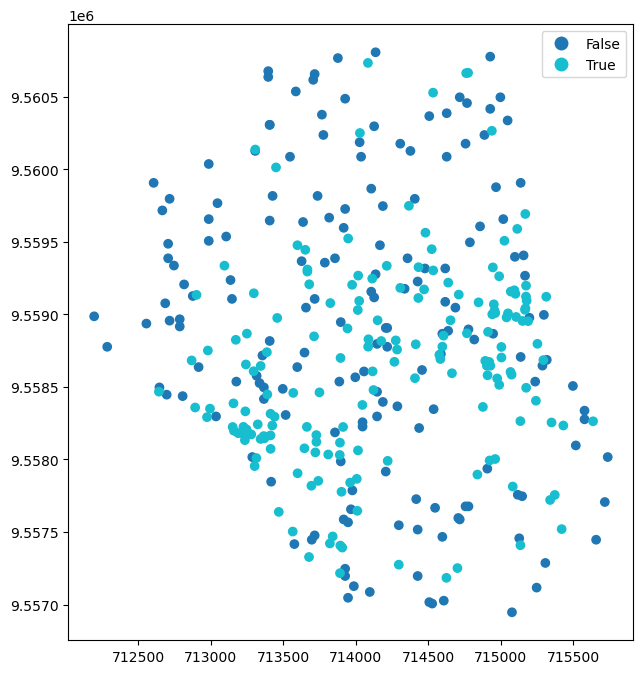

In [139]:
lsl_gpd = gpd.GeoDataFrame(lsl, 
                           geometry=gpd.points_from_xy(lsl['x'], lsl['y']), 
                           crs=32717)
lsl_gpd.plot('lslpts', legend=True, figsize=(8, 8))

Next let's load some environmental data to make predictions. This is in a multi-layer GeoTIFF file, and we can load it using the **rasterio** package. We start by opening a connection to the file, which lets us look at certain details (size, CRS, number of bands)


In [140]:
import rasterio
from rasterio.plot import show

#with rasterio.open('./datafiles/ta.tif') as dataset:
#    data = dataset.read(1) # Reads the first band
env_dataset = rasterio.open("./datafiles/ta.tif")
print(env_dataset.crs)
print(env_dataset.shape)

EPSG:32717
(415, 383)


Now we can read an individual layer and plot. Note that the band numbering starts at 1, so this is the first band (the `slope` values)

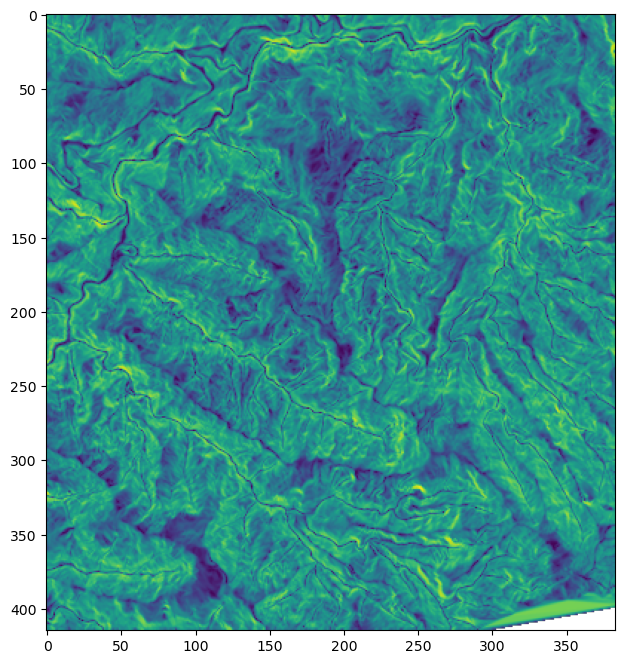

<Axes: >

In [141]:
arr1 = env_dataset.read(1)
plt.subplots(figsize=(8,8))
show(arr1)

In order to be able to use these values in model predictions, we need to convert to a 2D array, where every row is a single pixel and every column the corresponding value for one of the bands. As we know in this case that the order of the bands follows the same order as the columns in the `lsl` dataframe, we can do this with a simple reshape. First read all the data:

In [142]:
with rasterio.open('./datafiles/ta.tif') as src:
        env = src.read()
        metadata = src.meta

Now reshape. We first extract the dimensions of the the original image - we'll need these later to turn our predictions back into a raster format

In [143]:
# Reshape the image data
num_bands, height, width = env.shape
env_reshaped = env.reshape(num_bands, -1).T

The last thing we need to do before modeling is setup the array of features (`X`) and target (`y`). All the values are numeric and relatively normally distributed, so we don't need any other processing. 

In [144]:
lsl.columns

Index(['x', 'y', 'lslpts', 'slope', 'cplan', 'cprof', 'elev', 'log10_carea'], dtype='object')

In [145]:
all_vars = ['slope', 'cplan', 'cprof', 'elev', 'log10_carea']
X = lsl[all_vars]
y = lsl['lslpts']

## Baseline model

First, let's build a simple model using a classic train/test split (80/20) and evaluate it. First create the training/test split. Note that the data is well balanced (equal numbers of 1's and 0's) so we don't need to worry about stratifying the sample:


In [146]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

Now import a random forest classifier and train it. 

In [147]:
from sklearn.ensemble import RandomForestClassifier
lsl_rf = RandomForestClassifier()

lsl_rf.fit(X_train, y_train)

RandomForestClassifier()

And get the AUC score as a baseline measure of model performance

In [148]:
from sklearn.metrics import roc_auc_score

y_test_pred = lsl_rf.predict_proba(X_test)

lsl_auc = roc_auc_score(y_test, y_test_pred[:,1])
print(f'ROC AUC: {np.round(lsl_auc, 4)}')

ROC AUC: 0.9224


We get an AUC of around 0.85, which indicates a pretty good model. We'll dig into this more below.

Next, let's predict landslide susceptibility for the study region using the raster images we loaded above and extracted to the array `env_reshaped`. We then use the saved dimensions of the original image to convert this back to an array and plot

/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


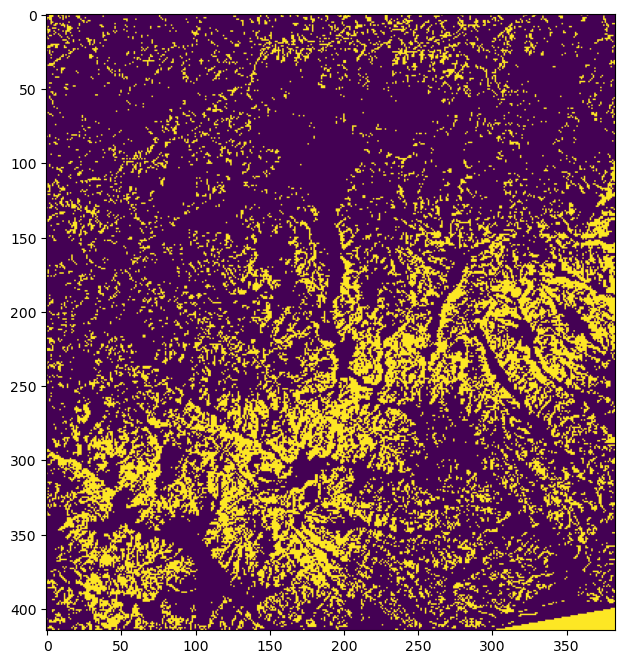

In [149]:
predictions_reshaped = lsl_rf.predict(env_reshaped)
    
predictions = predictions_reshaped.reshape(height, width)

plt.subplots(figsize=(8,8))
plt.imshow(predictions)


The map shows the distribution of predicted landslides (yellow) and non-landslides (purple). A more useful result would be to plot the probability and use tbhis as a measure of landslide susceptibility, which clearly shows a highly susceptible band runnning east-west in the lower half of the study area

/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


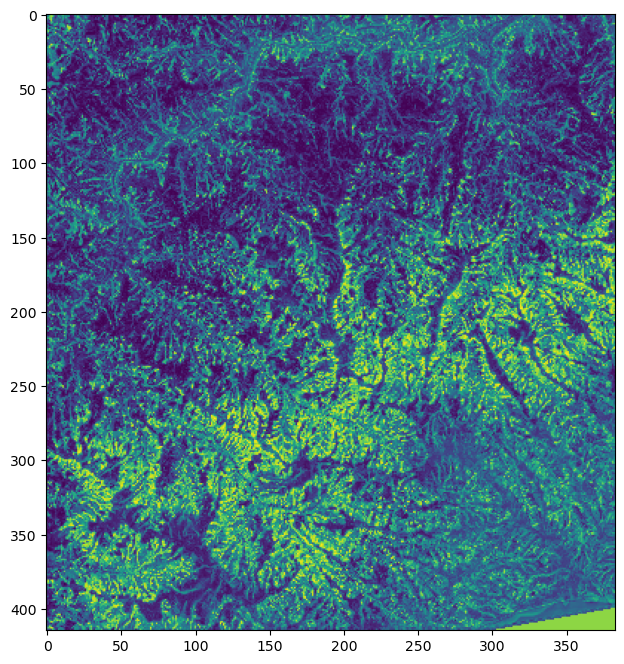

In [150]:
predictions_reshaped = lsl_rf.predict_proba(image_reshaped)
predictions = predictions_reshaped[:,1].reshape(height, width)

plt.subplots(figsize=(8,8))
plt.imshow(predictions)

We can save this results to a new GeoTiff to be able to import into a GIS platform or other software. This is a three step process where we first make a copy of the metadata from the original image, update the number of bands to 1 (as we only have a single layer to export) and write to the new file

In [151]:
# Update metadata for the new GeoTIFF
metadata_pred = metadata
metadata_pred['count'] = 1  # Single-band output
    
# Save the prediction as a new GeoTIFF
with rasterio.open('./datafiles/predicted_lsl.tif', 'w', **metadata_pred) as dst:
        dst.write(predictions, 1)

## Spatial cross-validation

Now let's dig a little further into the cross-validation of this model. The AUC value we got above is from a single hold-out, ignoring the spatial distribution of the observations.

First, let's re-run this as a 5-fold cross-validation to get a more robust estimate. For this we:

-   Set up a $k$-fold cross-validation strategy
-   Instantiate a random forest (we could simply reuse the code above, but adding this here helps clarify what is going on)
-   Run the cross-validation and check the results

In [152]:
from sklearn.model_selection import KFold, cross_val_score

n_splits=5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [153]:
lsl_rf = RandomForestClassifier()
scores = cross_val_score(lsl_rf, X, y, cv=cv, scoring = 'roc_auc')
print(f"AUC mean: {np.round(np.mean(scores), 3)}; AUC sd {np.round(np.std(scores), 3)}")

AUC mean: 0.853; AUC sd 0.021


And we get a similar, but more robust AUC estimate. However, we still haven't accounted for the spatial dependency in the data. This means that the value we have is somewhat reliant on the spatial correlation between the training and test set, as the observations are mixed. This means that our AUC value is really telling us about how well the model predicts *within* existing observations, in other words, how well it can interpolate.

To illustrate this, let's extract the fold IDs (i.e. which training fold each observation belongs to) to show how these are distributed

<Axes: >

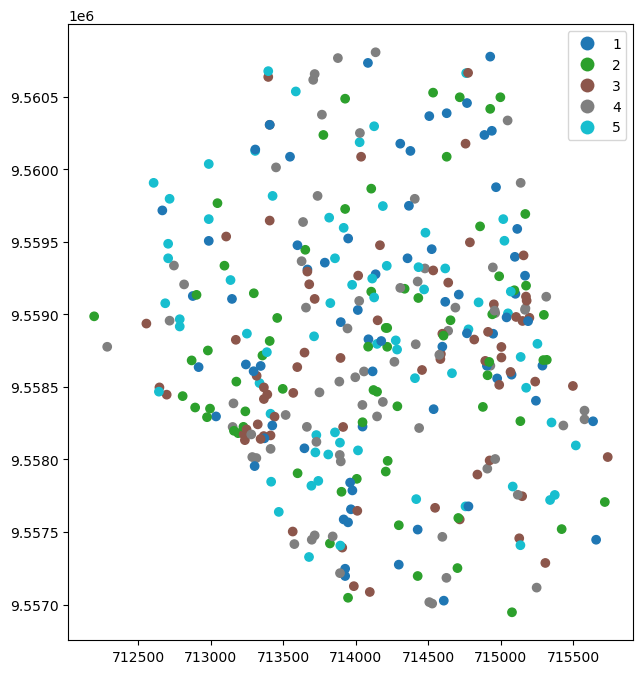

In [154]:
lsl_gpd['foldID'] = '0'

i = 1
for split in cv.split(X):
    #print(split)
    lsl_gpd.loc[split[1],'foldID'] = str(i)
    i += 1

lsl_gpd.plot('foldID', legend=True, figsize=(8,8))

A different test is how well our model would work in an area where we know the features, but we don't have any observations of landslides (or non-landslides). This will tell us how well the model works at predicting *outside* existing observations, or how well it can extrapolate. To test this, we need to use a spatial sampling method that will divide the data into contiguous training and testing regions. In a spatial $k$-fold, we divide the data into $k$ regions, set one as testing and the others as training, fit and evaluate a model and repeat. 

There's a number of ways to do this. We'll use a simple clustering algorithm based on the coordinates to cluster observations into contiguous regions. We'll do this by hand here, but if you are interested in exploring this further, see https://github.com/SamComber/spacv for more options)

We're going to explore cluster analysis in a few weeks, so I won't comment the code below. We'll just run it and plot the results

In [155]:
from sklearn.cluster import KMeans

crds = lsl[['x','y']]
kmeans = KMeans(n_clusters=n_splits, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(crds)

<Axes: >

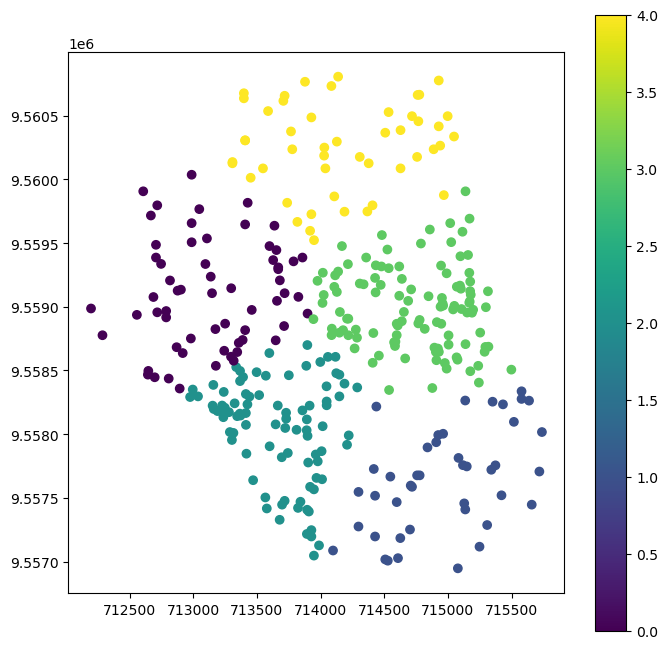

In [156]:
lsl_gpd['foldID'] = clusters
lsl_gpd.plot('foldID', legend=True, figsize=(8,8))

We can now use thes cluster assignments to create a new set of folds for cross-validation using `GroupKFold`. 

In [157]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=n_splits)

# Generator for the train/test indices
cv_sp = group_kfold.split(X, y, clusters)

And re-run the 5-fold crossvalidation with this:

In [158]:
scores = cross_val_score(lsl_rf, X, y, cv=cv_sp, scoring = 'roc_auc')
print(f"AUC mean: {np.round(np.mean(scores), 3)}; AUC sd {np.round(np.std(scores), 3)}")

AUC mean: 0.74; AUC sd 0.073


You should see here that the AUC decreases substantially, indicating less predictive power when extrapolating.


## Using location in machine learning

We'll now move on to exploring the use of location in machine learning. We'll look at this in three ways

-   Geographical random forest (GRF)
-   Using coordinates as features
-   Spatial basis functions

We'll also use a different data set here, with a continuous outcome, as the current GRF implementation does not work (well) with with binary outcomes.

The file *data_atlantic_1998_2012.csv* contains information on cancer rates from around 660 counties in the eastern part of the US. Let's load that here as well as a shapefile containing the county polygons:

In [159]:
cancer = pd.read_csv("./datafiles/data_atlantic_1998_2012.csv")
cancer.head()

,FIPS,x,y,Cancer,Poverty,Smoking,PM25,NO2,SO2
0,13111,1056523.936,1376613.190,72,15.920000,27.933333,11.755333,0.977667,0.064185
1,42115,1653442.064,2267301.476,59,12.220000,26.966667,9.026000,1.499933,0.033211
2,42075,1633708.275,2096683.059,61,8.986667,25.273333,11.963333,3.616467,0.120281
3,51683,1584048.852,1901443.401,62,7.860000,22.900000,12.731333,3.621933,0.118371
4,36057,1735811.102,2409536.493,59,14.746667,27.180000,8.302000,1.632733,0.006404


<Axes: >

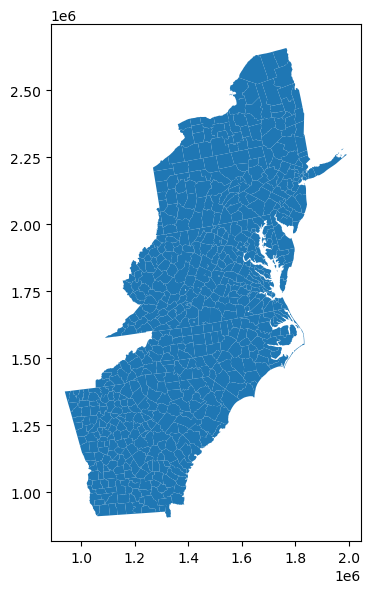

In [160]:
atl = gpd.read_file("./datafiles/COUNTY_ATLANTIC.shp")
atl.plot(figsize=(4,8))

Both the shapefile and the cancer data have the county FIPS code, so we can use this to merge the two datasets together, which allows us to map out the cancer rates, showing high rates in the south and western part of the region:

<Axes: >

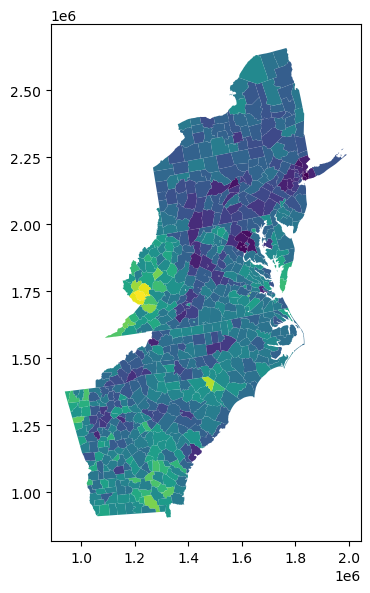

In [161]:
atl_cancer = atl.merge(cancer, on="FIPS")
atl_cancer.plot("Cancer", figsize=(4,8))

### Geographical random forest

Let's start this section by building a GRF with these data. To keep things simple here and below, we'll just use the pollutant variables as features (`PM25`, `NO2` and `SO2`). The GRF function uses a similar syntax to **scikit-learn** models, but needs a second dataframe with the coordinates of each spatial location. We'll extract this from the `geopandas` object by finding the centroids, and then the coordinates of these. We'll also make the usually `X` and `y` arrays for features and targets

In [162]:
atl_crds = atl_cancer.centroid.get_coordinates()

all_vars = ["PM25","NO2","SO2"]
X = cancer[all_vars]
y = cancer['Cancer']

Now we can fit the model. We won't try and tune this here, but instead run it with an adaptive kernel that uses the 50 closest locations to build each model in a moving window (you might want to try playing with the `band_width` argument to see how this affects the results). Note the other arguments:

- `train_weighted`: weight training samples by distance to current location
- `predict_weighted`: Use all local models within `band_width` to make predictions at new location or the closest
- `bootstrap`: bootstrap resample the training data

In [163]:
from PyGRF import PyGRF
grf = PyGRF.PyGRFBuilder(n_estimators=100, max_features=1, 
                         band_width=50, kernel="adaptive",
                         train_weighted=True, predict_weighted=True, 
                         bootstrap=True, random_state=42)

grf.fit(X,y, atl_crds)

(array([76.48837209, 65.03448276, 68.55813953, 63.71794872, 66.6       ,
        69.78571429, 73.23529412, 69.44117647, 73.61111111, 71.975     ,
        68.11111111, 75.29411765, 58.2       , 66.19512195, 71.06451613,
        81.0625    , 64.51111111, 63.69047619, 67.23404255, 71.81818182,
        74.93939394, 62.97435897, 70.79487179, 54.17391304, 81.22857143,
        84.7       , 81.34883721, 69.05714286, 68.5       , 67.71052632,
        76.26315789, 83.35135135, 74.20930233, 68.33333333, 72.18421053,
        81.55      , 50.        , 76.775     , 49.18421053, 67.63043478,
        63.125     , 69.2       , 68.16666667, 64.96875   , 69.06060606,
        66.1875    , 57.85714286, 68.59459459, 72.6097561 , 80.32258065,
        78.69230769, 85.375     , 75.63888889, 72.51612903, 70.25      ,
        70.5       , 71.85      , 76.59459459, 80.57575758, 70.60526316,
        75.1       , 82.25714286, 66.73076923, 65.85365854, 64.5       ,
        63.        , 72.76315789, 71.73809524, 70.1

The function will give you quite a lot of output. The routine starts by fitting a global model (i.e. with all the observations) and then fits local models to each observation using the kernel we defined in the function. 

More usefully, we can start to visualize the results. First we'll explore the importance of the three features we used in the model. As a remidner, this is a measure of the loss of predictive power when one of the variables is randomly shuffled. Let's start by plotting the importance scores for the global model:

In [164]:
grf.global_model.feature_importances_

array([0.3053183 , 0.38632595, 0.30835574])

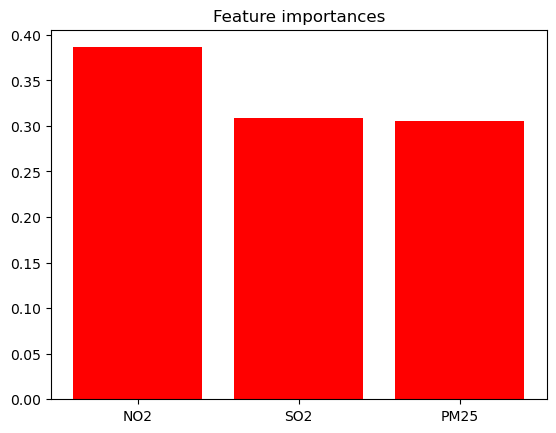

In [165]:
importances = grf.global_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.array(all_vars)[indices], 
        importances[indices],
        color="r", align="center")
plt.show()

Next, let's get the local importance scores. In the model output, there is a method called `get_local_feature_importance` which (unsurprisingly) extracts the importance scores for each model (for each location). A second method (`get_local_R2`) gets goodness of fit scores for each location and we'll use this to visualize variations in the R2:

In [166]:
loc_vip = grf.get_local_feature_importance()

/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/PyGRF/PyGRF.py:319: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance_df = pd.concat([feature_importance_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


Text(0.5, 1.0, 'PM2.5')

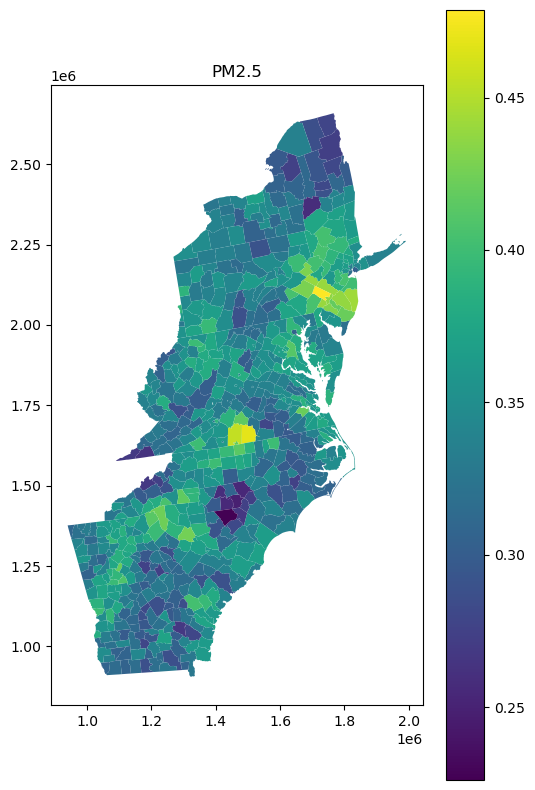

In [167]:
atl_cancer['PM25_vip'] = loc_vip['PM25']
atl_cancer.plot('PM25_vip', legend=True, figsize=(6,10))
plt.title("PM2.5")

Text(0.5, 1.0, 'NO2')

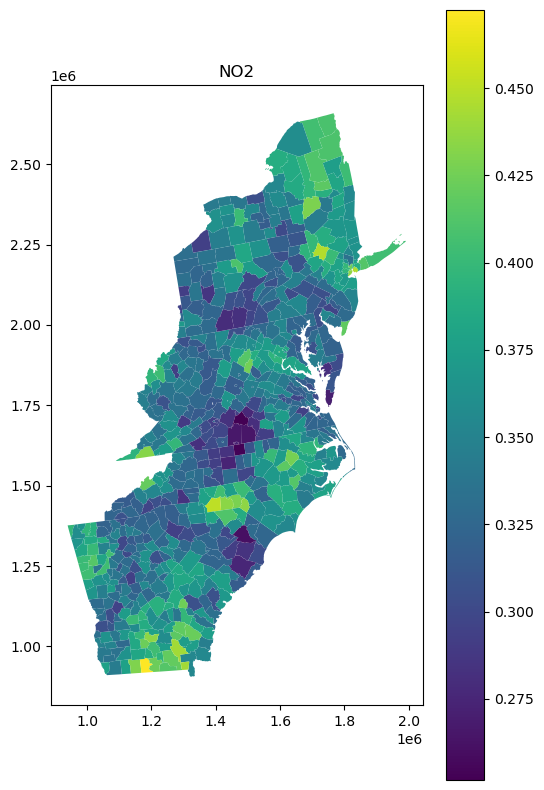

In [168]:
atl_cancer['NO2_vip'] = loc_vip['NO2']
atl_cancer.plot('NO2_vip', legend=True, figsize=(6,10))
plt.title("NO2")

Text(0.5, 1.0, 'SO2')

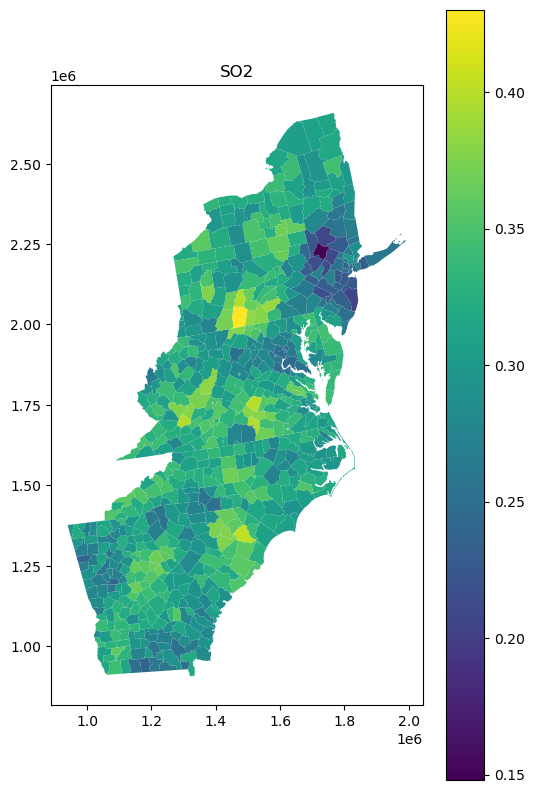

In [169]:
atl_cancer['SO2_vip'] = loc_vip['SO2']
atl_cancer.plot('SO2_vip', legend=True, figsize=(6,10))
plt.title("SO2")

/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/PyGRF/PyGRF.py:344: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  R2_df = pd.concat([R2_df, pd.DataFrame([this_row], columns=column_list)], ignore_index=True)


Text(0.5, 1.0, 'Local R2')

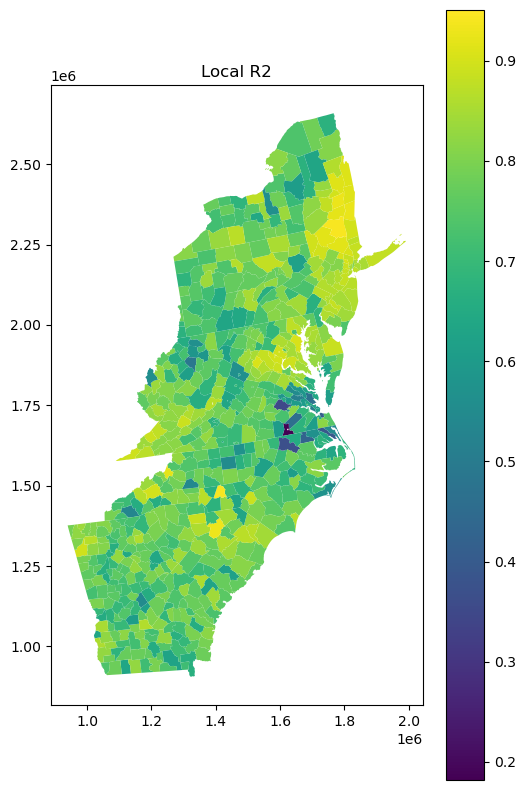

In [170]:
loc_r2 = grf.get_local_R2()
atl_cancer['loc_r2'] = loc_r2['local R2']

atl_cancer.plot('loc_r2', legend=True, figsize=(6,10))
plt.title("Local R2")

A few things to note from these maps:

-   The local R2 values vary a lot (with some regions that have negative values). This can be interpreted as a map of where the model is doing a reasonable job (green) and where it fails (red). The low values indicate that other variables may be important in producing this model
-   The importance scores for the three features largely follow the same pattern (high importance around metropolitan centers, low elsewhere). This is not too surprising as pollutant values tend to correlate pretty strongly.

## Using coordinates as features

Next, we'll explore the use of coordinates as features. Conceptually, we are trying to improve the model outcome by incorporating some measure of spatial dependency or autocorrelation between locations. This helps to address models that tend to over- or under-estimate systematically in space. To illustrate this point, we'll first make a random forest model using all the data:


In [172]:
from sklearn.ensemble import RandomForestRegressor

all_vars = ["PM25","NO2","SO2"]
X = cancer[all_vars]
y = cancer['Cancer']

cancer_rf = RandomForestRegressor()
cancer_rf.fit(X,y)

RandomForestRegressor()

Now predict and merge into the `geopandas` object:

In [173]:
atl_cancer['yhat'] = cancer_rf.predict(X)

Calculate the error as prediction - observation and plot:

Text(0.5, 1.0, 'RF errors')

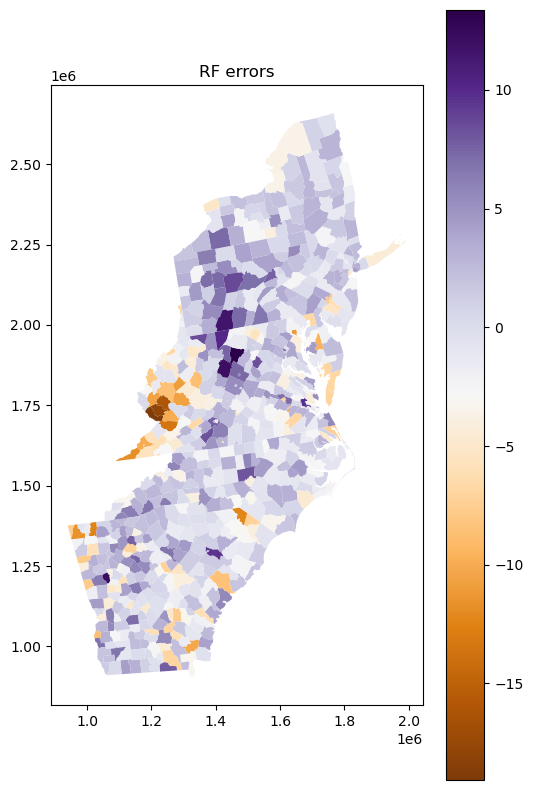

In [175]:
atl_cancer['error'] = atl_cancer['yhat'] - atl_cancer['Cancer']

atl_cancer.plot('error', legend=True, figsize=(6,10), cmap="PuOr")
plt.title("RF errors")

And these results show that systematic error in the model (note the patches of negative values and positive values). Before including the coordinates in a model, let's run a 5-fold cross-validation on this model to get a reference RMSE and $R^2$.

In [176]:
n_splits=5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

scores = cross_val_score(cancer_rf, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')
print(f"RMSE mean: {np.round(np.mean(-scores), 3)}; RMSE sd {np.round(np.std(-scores), 3)}")

RMSE mean: 10.821; RMSE sd 0.481


Now let's re-run this with coordinates included (these are in the `x` and `y` columns or we could use the centroid coordinates we extracted earlier):

In [177]:
all_vars = ["PM25","NO2","SO2","x","y"]
X = cancer[all_vars]
y = cancer['Cancer']

scores = cross_val_score(cancer_rf, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')
print(f"RMSE mean: {np.round(np.mean(-scores), 3)}; RMSE sd {np.round(np.std(-scores), 3)}")

RMSE mean: 8.894; RMSE sd 0.499


And we get a pretty substantial improvement in model performance, with around a 2 point drop in RMSE.


## Exercise

For the exercise, you will need to submit two things:

- A table listing the AUC and accuracy for the three different algorithms (decision trees, random forest and boosted regression). You should give these values based on predictions for the *test* dataset using the final model.
- A map showing predicted *probability* of Pinus edulis presence under *current* environmental conditions using *either* the decision tree model or the boosted regression

Students enrolled in 6160 should also provide

- A map showing predicted *probability* of Pinus edulis presence under *future* environmental conditions using the same model as in part 2
- A map showing the difference between the future and current predicted presence for the same model

Use a new notebook to record your answers and output. These should be submitted to Canvas by February 12th. Please use the following naming convention: `Lab03_lastname.ipynb`.



## 6160 Students

In addition to the above exercise, you should build and evaluate a second logistic regression model for houses with high or low area.

-   Use a cutoff of 10,000 sq ft. (higher should be labeled as `high`)
-   Use 4-fold cross-validation
-   Report the accuracy, recall and specificity
-   Optional: why do you think there is such a large difference between recall and specificity in this model?

## Appendix

## Appendix 1: Bioclimate variables

- BIO1 = Annual Mean Temperature
- BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
- BIO3 = Isothermality (BIO2/BIO7) (* 100)
- BIO4 = Temperature Seasonality (standard deviation *100)
- BIO5 = Max Temperature of Warmest Month
- BIO6 = Min Temperature of Coldest Month
- BIO7 = Temperature Annual Range (BIO5-BIO6)
- BIO8 = Mean Temperature of Wettest Quarter
- BIO9 = Mean Temperature of Driest Quarter
- BIO10 = Mean Temperature of Warmest Quarter
- BIO11 = Mean Temperature of Coldest Quarter
- BIO12 = Annual Precipitation
- BIO13 = Precipitation of Wettest Month
- BIO14 = Precipitation of Driest Month
- BIO15 = Precipitation Seasonality (Coefficient of Variation)
- BIO16 = Precipitation of Wettest Quarter
- BIO17 = Precipitation of Driest Quarter
- BIO18 = Precipitation of Warmest Quarter
- BIO19 = Precipitation of Coldest Quarter